In [145]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import pickle

from abc import ABC, abstractmethod

import os

from skopt import Optimizer
from skopt.space import Real

import scipy.stats as st

from rich.table import Table
from rich.console import Console

from joblib import Parallel, delayed

from scipy.special import softmax

from collections import namedtuple, deque


import torch

# Traccia A3
L’obiettivo del progetto è implementare e valutare una o più soluzioni basate su reinforcement learning per il problema Mountain Car della suite OpenAI Gymnasium: https://gym.farama.org/environments/classic_control/mountain_car/

## Descrizione
Il MountainCar-v0 è un ambiente deterministico in cui una macchina deve raggiungere la cima di una collina vincendo la gravità. La macchina è inizialmente posizionata in una valle e l'agente deve usare l'accelerazione in modo strategico per raggiungere l'obbiettivo.

### Spazio di Stato
- **Shape:** `(2,)`
- **Elements:**
  - Posizione: `[-1.2, 0.6]` (m)
  - Velocità: `[-0.07, 0.07]` (m/s)

### Spazio delle Azioni
**Discrete(3)**
1. Accelerare sx
2. Non Accelerare
3. Accelerare dx

### Dinamica
Aggiornamento basato su forza, velocità e gravità. Ai confini ci sono degli urti anelstici.

### Reward
Costante: reward di $-1$ per ogni step fino al raggiungimento dell'obbiettivo.

### Stato Iniziale
- Posizione: Uniform random in `[-0.6, -0.4]`
- Velocità: `0`

### Fine Episodio
1. **Terminazione:** Posizione ≥ 0.5 (goal reached)
2. **Troncamento:** 200 timesteps


In [146]:
PROBLEM_NAME = 'MountainCar-v0'

MAX_EPISODE_STEPS = 200
SPACE_RANGE = [-1.2, 0.6]
VEL_RANGE = [-0.07, 0.07]
ACTION_SPACE = 3

# Aspetti Generali

Di seguito vengono definite le tre classi a partire dal quale viene generalizzato il problema:
* La classe *QFunction* definisce un'implementazione della Action Value Function. L'uso di questa classe permette di costruire delle Policy che siano indipendenti dalla particolare implementazione della funzione
* La classe *Policy* definisce un'implementazione di una Politica. Le azioni che la politica restituisce potranno essere sia casuali (esplorazione) sia dettate dai volori attuali della *QFunction* data (sfruttamento della conoscenza acquisita).
* La classe *Agent* definisce un agente che interagisce con l'ambiente seguendo le azioni dettate dalla politica che segue.

I seed passati ai vari metodi sono usati per l'inizializzazione dell'ambiente e dei generatori di numeri casuali al fine di avere la riproducibilità tra run diverse.

In [147]:
class QFunction(ABC) :

    @abstractmethod
    def updateFunction(self, currentState, action, reward, nextState, terminated, alpha, gamma, targetValue) :
        pass

    @abstractmethod
    def getValue(self, state, action) -> float :
        pass

    @abstractmethod
    def getValues(self, state) -> np.ndarray :
        pass

In [148]:
class Policy(ABC) :
    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction) :
        self.alpha = alpha
        self.gamma = gamma
        self.explorePerc = explorePerc

        self.function = function

    
    @abstractmethod
    def chooseAction(self, state, training) -> int :
        pass

    @abstractmethod
    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        pass

    @abstractmethod
    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        pass


In [149]:
class Agent :

    def __init__(self, policy : Policy) :
        self.policy = policy

    def oneEpisode(self, env : gym.Env, training : bool) -> list:
        currentState = env.reset()[0]
        done = False
        totalReward = 0
        while (not done) :
            action = self.policy.chooseAction(currentState, training)
            nextState, reward, terminated, truncated, _ = env.step(action)

            done = terminated or truncated
            if training :
                self.policy.updatePolicy(currentState, action, reward, nextState, terminated)

            currentState = nextState
            totalReward += reward
            
        return totalReward


    def train(self, episodeNum : int, seed : int) -> np.ndarray :
        env : gym.Env = gym.make(PROBLEM_NAME)

        env.reset(seed = seed)
        env.action_space.seed(seed = seed)

        rewardArray = np.zeros(episodeNum)
        for episodeIdx in range(0, episodeNum) :
            episodeReward = self.oneEpisode(env = env, training = True)

            rewardArray[episodeIdx] = episodeReward

            self.policy.updateParams(episodeNum, episodeIdx)

        env.close()

        return rewardArray
    

    def test(self, episodeNum : int, seed : int, display : bool) -> np.ndarray :
        env : gym.Env = gym.make(PROBLEM_NAME, render_mode = "human" if display else None)
        
        env.reset(seed = seed)
        env.action_space.seed(seed = seed)

        rewardArray = np.zeros(episodeNum)
        for episodeIdx in range(0, episodeNum) :
            episodeReward  = self.oneEpisode(env, False)
            rewardArray[episodeIdx] = episodeReward

        env.close()

        return rewardArray
    
    def getPolicy(self) -> Policy :
        return self.policy


In [150]:
TRAIN_SEED = 0
TUNE_SEED = 1
TEST_SEED = 2

TUNER_RANDOM_STATE = 3
TORCH_RANDOM_STATE = 4

In [151]:
TRAIN_EPISODES = 5_000
TUNE_EPISODES = 100
TEST_EPISODES = 100

## Policy

Di seguito vengono proposte due implementazioni di Policy, una basata su Q-Learning e l'altra basata su Sarsa.

Nelle implementazioni proposte è stato adottato:
* Un approccio $\epsilon$-greedy con decadimento lineare dell'$\epsilon$.
* Un approccio Softmax Action Selection con decadimento lineare del $\tau$.
Il tasso di decadimento in entrambi i casi è determinato in funzione di un parametro che rappresenta la percentuale di episodi di addestramento in cui si vuole che si raggiunga il valore minimo dell'$\epsilon$ o del $\tau$. 

In entrambi i casi vengono inizializzati dei generatori di numeri randomici per l'esplorazione e la scelta della prossima azione casuale.

Come riportato in https://gymnasium.farama.org/tutorials/gymnasium_basics/handling_time_limits/, quando si raggiunge lo stato terminale, il valore $Q(s_{t+1}, *)$ non può essere definito, in quanto l'interazione agente-ambiente è terminata e non esiste in realtà uno stato successivo. Il valore del parametro *terminated* viene quindi usato proprio per discriminare queste situazioni e porre il valore del target come uguale al reward.

Il valore del target così calcolato viene passato come parametro alla function insieme anche alle informazioni $(s_t, a_t, r_t, s_{t+1})$ in modo da avere maggior flessibilità nell'aggiornamento della funzione (e.g. la soluzione con approssimazione basata su DQN non vuole il valore del taget, ma vuole le altre informazioni).

Per la scelta delle azioni è stato implementato un doppio approccio:
* Approccio di esplorazione/sfruttamento in caso di addestramento
* Approccio di puro sfruttamento in caso di test. In caso di test la qFunction associata non viene aggiornata.

### Q-Learning
In questo algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma \cdot max_{a} Q(S_{t+1},a) - Q(S_t,A_t)]$

In [152]:
class EpsilonQ(Policy) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, epsilon : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.seed = seed
        self.baseEpsilon = epsilon
        self.epsilon = epsilon

        self.exploreRng = np.random.default_rng(seed)
        self.actionChooseRng = np.random.default_rng(seed)


    def chooseAction(self, state, training) -> int :
        if (not training) :
            return np.argmax(self.function.getValues(state))
        
        if (self.exploreRng.random() < self.epsilon) :
            return self.actionChooseRng.choice(ACTION_SPACE)
        else :
            return np.argmax(self.function.getValues(state))


    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        target = reward
        if (not terminated) :
            target += self.gamma * np.max(self.function.getValues(nextState))
        self.function.updateFunction(state, action, reward, nextState, terminated, self.alpha, self.gamma, target)


    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseEpsilon - 0.0001)
        else :
            self.epsilon = 0.0001
        

In [153]:
class TauQ(Policy) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, epsilon : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.seed = seed
        self.baseEpsilon = epsilon
        self.epsilon = epsilon

        self.exploreRng = np.random.default_rng(seed)
        self.actionChooseRng = np.random.default_rng(seed)


    def chooseAction(self, state, training) -> int :
        distribution = softmax(self.function.getValues(state) / self.epsilon)
        if (not training) :
            return np.argmax(distribution)
        
        return self.actionChooseRng.choice(ACTION_SPACE, p = distribution)


    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        target = reward
        if (not terminated) :
            target += self.gamma * np.max(self.function.getValues(nextState))
        self.function.updateFunction(state, action, reward, nextState, terminated, self.alpha, self.gamma, target)


    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseEpsilon - 0.0001)
        else :
            self.epsilon = 0.0001
        

### Sarsa-Learning
In questo algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t)]$

Dove $A_{t+1}$ è scelta con la stessa politica usata per scegliere l'azione $A_t$.

In [154]:
class EpsilonSarsa(Policy) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, epsilon : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.seed = seed
        self.baseEpsilon = epsilon
        self.epsilon = epsilon

        self.exploreRng = np.random.default_rng(seed)
        self.actionChooseRng = np.random.default_rng(seed)

    def chooseAction(self, state, training) -> int :
        if (not training) :
            return np.argmax(self.function.getValues(state))
        
        if (self.exploreRng.random() < self.epsilon) :
            return self.actionChooseRng.choice(ACTION_SPACE)
        else :
            return np.argmax(self.function.getValues(state))


    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        target = reward
        if (not terminated) :
            nextAction = self.chooseAction(nextState, True)
            target += self.gamma * self.function.getValue(nextState, nextAction)
        self.function.updateFunction(state, action, reward, nextState, terminated, self.alpha, self.gamma, target)


    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseEpsilon - 0.0001)
        else :
            self.epsilon = 0.0001

In [155]:
class TauSarsa(Policy) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, epsilon : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.seed = seed
        self.baseEpsilon = epsilon
        self.epsilon = epsilon

        self.exploreRng = np.random.default_rng(seed)
        self.actionChooseRng = np.random.default_rng(seed)

    def chooseAction(self, state, training) -> int :
        distribution = softmax(self.function.getValues(state) / self.epsilon)
        if (not training) :
            return np.argmax(distribution)
        
        return self.actionChooseRng.choice(ACTION_SPACE, p = distribution)


    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        target = reward
        if (not terminated) :
            nextAction = self.chooseAction(nextState, True)
            target += self.gamma * self.function.getValue(nextState, nextAction)
        self.function.updateFunction(state, action, reward, nextState, terminated, self.alpha, self.gamma, target)


    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseEpsilon - 0.0001)
        else :
            self.epsilon = 0.0001

# Tuning
Definiamo di seguito una classe generica per il tuning degli iperparametri.

La sintonizzazione è stata effettuata con l'uso della libreria *scikit-optimize* che permette una valutazione in parallelo dei punti: la classe Optimizer esegue un'ottimizzazione bayesiana dei punti cercando il punto ottimo nello spazio degli iperparametri specificati.

Il tuning è stato eseguito:
1. Addestrando gli agenti partendo sempre dallo stesso seed
2. Valutando gli agenti addestrati su un ambiente inizializzato con un seed diverso
3. Prendendo come parametro di riferimento il reward medio ottenuto in valutazione

In [156]:
class Tuner(ABC) :

    def __init__() :
        pass

    @abstractmethod
    def objective(self, params) :
        pass

    def tune(self, calls, randomState, space, jobsNum) :
        optimizer = Optimizer(
            dimensions = space, 
            random_state = randomState,
        )

        for i in range(calls // jobsNum):
            print(f"Step >>> {i}")
            x = optimizer.ask(n_points=jobsNum)  # x is a list of n_points points
                
            y = Parallel(
                n_jobs = jobsNum
            )(delayed(self.objective)(params) for params in x)  # evaluate points in parallel
            optimizer.tell(x, y)

            bestIdx = np.argmin(optimizer.yi)
            print(f"Best Value So Far >>> {optimizer.yi[bestIdx]}")
            print(f"Best Params So Far >>> {optimizer.Xi[bestIdx]}")
            print()
        
        bestIdx = np.argmin(optimizer.yi)
        print(f"Best Value >>> {optimizer.yi[bestIdx]}")
        print(f"Best Params >>> {optimizer.Xi[bestIdx]}")
        print()
        print()

        return optimizer.Xi[bestIdx]

# Utils

In [157]:
def buildTable(testName : str, headerList : list[str], justifyList: list[str]) -> Table:
    table = Table(title = testName)
    for i in range(0, len(headerList)) :
        table.add_column(headerList[i], justify = justifyList[i])
    return table

In [158]:
def plotTrainTrend(rewardArray : np.ndarray, episodeNum : int, learnerName : str) :
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

    axes[0].plot(np.array(rewardArray))
    axes[0].set_xlabel("Episode Idx")
    axes[0].set_ylabel("Reward")
    axes[0].set_title("Reward During Training")
    axes[0].grid(True)
    
    mean_rewards = np.zeros(episodeNum)
    for t in range(episodeNum):
            mean_rewards[t] = np.mean(rewardArray[max(0, t-100):(t+1)])
    axes[1].plot(mean_rewards)
    axes[1].set_xlabel("Episode Idx")
    axes[1].set_ylabel("Avg Reward - 100 Episodes")
    axes[1].set_title("Avg Reward Trend During Training")
    axes[1].grid(True)

    fig.suptitle(f"{learnerName} - Training")
    plt.tight_layout()
    plt.show()
    plt.clf()

In [159]:
def plotTestTrend(policyList : list[Policy], testEpisodes : int, testSeed : int) :

    plt.figure(figsize = (15,5))

    for policy in policyList :
        agent = Agent(policy)
        rewardArray = agent.test(testEpisodes, testSeed, False)
        plt.plot(rewardArray, label = policy.__class__.__name__, marker = "o")

        cumAvg = np.cumsum(rewardArray) / np.arange(1, len(rewardArray) + 1)
        plt.plot(cumAvg, label = policy.__class__.__name__ + " - Cum Reward Avg")

    plt.legend()
    plt.grid(True, axis = "y")
    plt.ylabel("Reward")
    plt.xlabel("Attempt Index")
    plt.title(f"Testing Trend")
    plt.tight_layout()
    plt.show()
    plt.clf()

In [160]:
def drawTestTable(policyList : list[Policy], testEpisodes : int, testSeed : int) :
    table = buildTable(f"Testing Reward Info", ["LearnerName", "Avg Reward", "Reward Std Dev", "Confidence Interval 95%"], [False, True, True, True])
    for policy in policyList :
        agent = Agent(policy)
        rewardArray = agent.test(testEpisodes, testSeed, False)
        confidenceInterval = st.t.interval(
            confidence = 0.95,
            df = len(rewardArray) - 1,
            loc=np.mean(rewardArray), 
            scale=st.sem(rewardArray)
        )
        confidenceString = str(confidenceInterval[0]) + " / " + str(confidenceInterval[1])
        table.add_row(policy.__class__.__name__, str(rewardArray.mean()), str(rewardArray.std()), confidenceString)
    
    Console().print(table)

# Soluzione con ricerca tabulare
Per definire delle soluzioni basate su ricerca tabulare, abbiamo bisogno prima di tutto di una matrice che ci tenga traccia dei valori della funzione $Q(s,a)$. In questo caso specifico lo stato del problema non è discreto, bensì continuo, in quanto formato da i valori della posizione e della velocità i quali a loro volta variano in un insieme continuo.

Al fine di definire delle soluzioni basate su ricerca tabulare quindi definiamo una discretizzazione dello stato che ci permetta di definire la funzione $Q(s,a)$; notiamo invece che per quanto riguarda l'insieme $A$ delle azioni esso è già discreto e non ci dà problemi in termini di definizione della funzione.

Una soluzione basata su questo tipo di soluzioni comporta un consumo di memoria dato da $|S| \cdot |A|$, dove $|A|$ nel nosto caso è pari a $3$, mentre $|S|$ dipende dalla discretizzazione che facciamo dello stato: supposto di dividere l'inervallo della posizione in $5$ slot e quello delle velocità in altrettanti, avremo un numero totale di stati pari a $25$.

In questo caso, come si vede dall'implementazione, il valore dell'incremento della funzione viene calcolato partendo dal target e applicando la relazione:   

$Q(S,A) \leftarrow Q(S,A) + \alpha [target - Q(S,A)]$

Dove il calcolo del target cambia a seconda che si tratti di Q-Learning o Sarsa.

In [161]:
class BucketQFunction(QFunction) :

    def __init__(self, spaceRange : list, spaceBins : int, velRange : list, velBins : int, actionSpace : int) :
        self.q : np.ndarray = np.zeros([spaceBins, velBins, actionSpace])

        self.spaceLinSpace = np.linspace(
            spaceRange[0], 
            spaceRange[1], 
            spaceBins + 1
        )

        self.velLinSpace = np.linspace(
            velRange[0], 
            velRange[1], 
            velBins + 1
        )

    def updateFunction(self, currentState, action, reward, nextState, terminated, alpha, gamma, targetValue):
        spaceSlot, velSlot = self._computeSlots(currentState)
        increment = alpha * (targetValue - self.getValue(currentState, action))

        self.q[spaceSlot, velSlot, action] += increment
    
    def getValue(self, state, action):
        spaceSlot, velSlot = self._computeSlots(state)
        return self.q[spaceSlot, velSlot, action]
    
    def getValues(self, state) :
        spaceSlot, velSlot = self._computeSlots(state)
        return self.q[spaceSlot, velSlot, :]
    
    def _computeSlots(self, state) -> tuple[int, int] :
        spaceSlot = np.digitize(state[0], self.spaceLinSpace) - 1
        velocitySlot = np.digitize(state[1], self.velLinSpace) - 1
        return spaceSlot, velocitySlot

## Tuning

Di seguito si procede alla sintonizzazione degli iperparametri.
Come iperparametri da sintonizzare sono stati considerati i seguenti:
* $\alpha$, learning rate
* $\gamma$, fattore di sconto
* $\epsilon$ (oppure $\tau$), parametro di esplorazione

Altri iperparametri che non sono stati calibrati, ma sono stati scelti ad occhio per non rallentare eccessivamente l'esecuzione sono stati:
* Numero di Episodi di Addestramento: impostato a $5000$
* Percentuale di Episodi di Esplorazione : impostato a $50\%$. Questo significa che per $2500$ episodi la probabilità di esplorazione è maggiore del minimo.
* Numero di bucket: impostato a $20$. Il valore permette una buona discretizzazione sia dello spazio sia della velocità. Nello specifico:
    * Lo spazio è diviso in intervalli di lunghezza $0.09$ metri, cioè $9$ cm
    * La velocità è divisa in intervalli di lunghezza $0.007$ m/s

Per non eseguire più volte il tuning degli iperparametri, questi vengono salvati su un file .pkl e letti da qui in caso che il file già esista.

In [162]:
class BucketTuner(Tuner) :

    def __init__(self, PolicyClass, trainEpisodes : int, tuneEpisodes : int, trainSeed : int, tuneSeed : int) :
        self.PolicyClass = PolicyClass
        self.trainEpisodes = trainEpisodes
        self.tuneEpisodes = tuneEpisodes
        self.trainSeed = trainSeed
        self.tuneSeed = tuneSeed

    def objective(self, params):
        alpha, gamma, epsilon = params

        function = BucketQFunction(SPACE_RANGE, 20, VEL_RANGE, 20, ACTION_SPACE)
        policy = self.PolicyClass(alpha, gamma, 0.5, function, self.trainSeed, epsilon)
        agent = Agent(policy)
        trainRewardArray = agent.train(self.trainEpisodes, self.trainSeed)
        tuneRewardArray= agent.test(self.tuneEpisodes, self.tuneSeed, False)
        
        meanTune = -tuneRewardArray.mean()
        objValue = meanTune
        return objValue

In [163]:
def tuneBucketLearner(Policy, trainEpisodes, bestDict, fileName : str) -> list :
    key = Policy.__name__
    if (not key in bestDict) :
        space = [
            Real(0.01, 0.4, name = 'alpha'),
            Real(0.8, 1.0, name = 'gamma'),
            Real(0.5, 1.0, name = "epsilon"),
        ]
        bestParams = BucketTuner(Policy, trainEpisodes, TUNE_EPISODES, TRAIN_SEED, TUNE_SEED).tune(150, TUNER_RANDOM_STATE, space, 5)
        bestDict[key] = bestParams
        with open(fileName, 'wb') as f:
            pickle.dump(bestDict, f)
    else :
        bestParams = bestDict[key]

    return bestParams

## Epsilon-Learning

### Tuning

In [164]:
EPSILON_PARAMS_FILE_NAME = './EpsilonParams.pkl'

if (os.path.exists(EPSILON_PARAMS_FILE_NAME)) :
    with open(EPSILON_PARAMS_FILE_NAME, 'rb') as f:
        epsilonParamsDict = pickle.load(f)
else :
    epsilonParamsDict = {}

tuneBucketLearner(EpsilonQ, TRAIN_EPISODES, epsilonParamsDict, EPSILON_PARAMS_FILE_NAME)
tuneBucketLearner(EpsilonSarsa, TRAIN_EPISODES, epsilonParamsDict, EPSILON_PARAMS_FILE_NAME)


[0.19525669292857453, 1.0, 0.5]

In [165]:
table = buildTable("Best Params", ["LearnerName", "Alpha", "Gamma", "Epsilon"], [False, False, True, True, True])
for key in epsilonParamsDict :
    table.add_row(key, str(epsilonParamsDict[key][0]), str(epsilonParamsDict[key][1]), str(epsilonParamsDict[key][2]))

Console().print(table)

                             Best Params                             
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ LearnerName  ┃ Alpha               ┃ Gamma              ┃ Epsilon ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ EpsilonQ     │ 0.16780241574652063 │ 0.9549550734445448 │ 0.5     │
│ EpsilonSarsa │ 0.19525669292857453 │ 1.0                │ 0.5     │
└──────────────┴─────────────────────┴────────────────────┴─────────┘

### Addestramento
Trovati i parametri migliori procediamo all'addestramento degli agenti con questi parametri e a tracciare le curve di addestramento. Anche in questo caso salviamo le policy addestrate su un file .pkl per non addestrarle più volte così come salviamo gli array dei reward ottenuti durante gli episodi di addestramento in modo da poterli graficare.

In [166]:
EPSILON_TRAINED_FILE_NAME = "./EpsilonTrained.pkl"

def trainAgent(PolicyClass, fileName, trainDict, bestParamsDict, episodeNum) -> tuple[Policy, np.ndarray] :
    key = PolicyClass.__name__
    if (not key in trainDict) :
        alpha, gamma, epsilon = bestParamsDict[key]
        function = BucketQFunction(SPACE_RANGE, 20, VEL_RANGE, 20, ACTION_SPACE)
        policy = PolicyClass(alpha, gamma, 0.5, function, TRAIN_SEED, epsilon)
        agent = Agent(policy)

        rewardArray = agent.train(episodeNum, TRAIN_SEED)
        
        trainDict[key] = [policy, rewardArray]
        with open(fileName, 'wb') as f:
            pickle.dump(trainDict, f)
    else :
        policy : Policy = trainDict[key][0]
        rewardArray = trainDict[key][1]
    
    plotTrainTrend(rewardArray, episodeNum, key)

    return policy, rewardArray

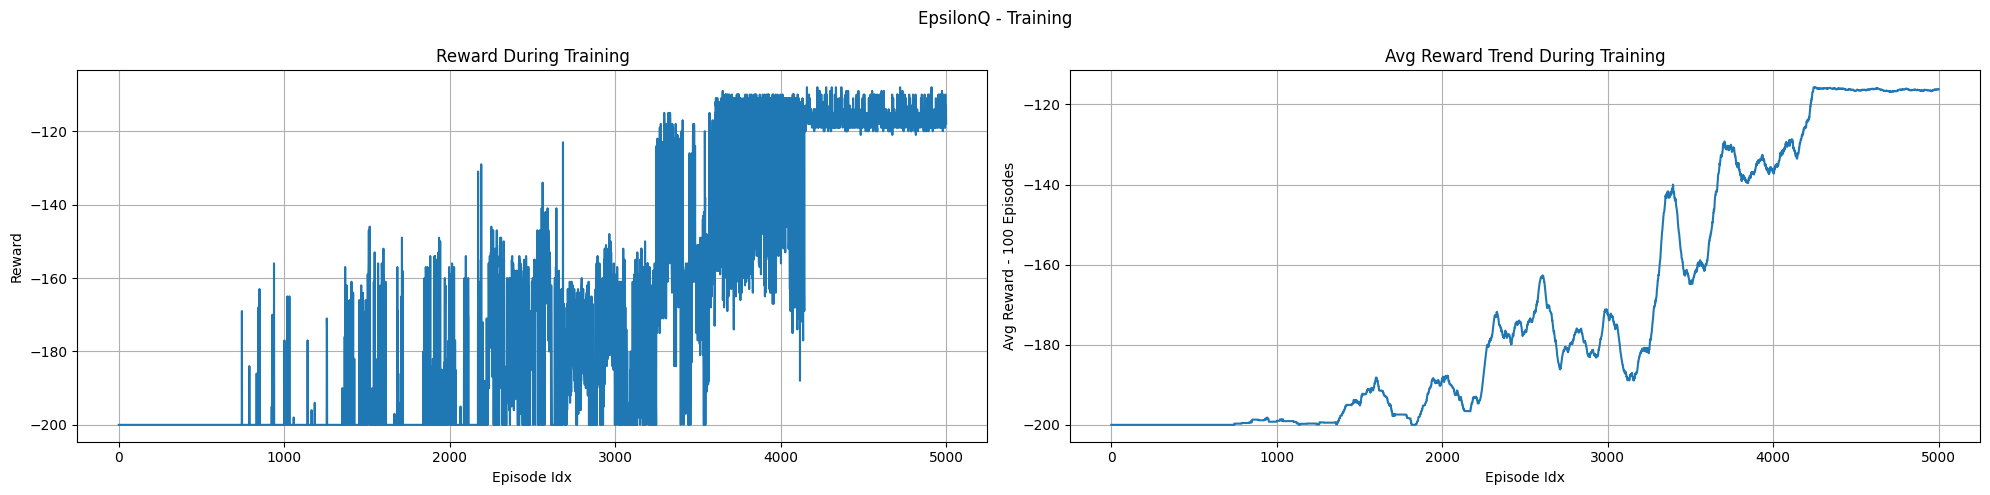

<Figure size 640x480 with 0 Axes>

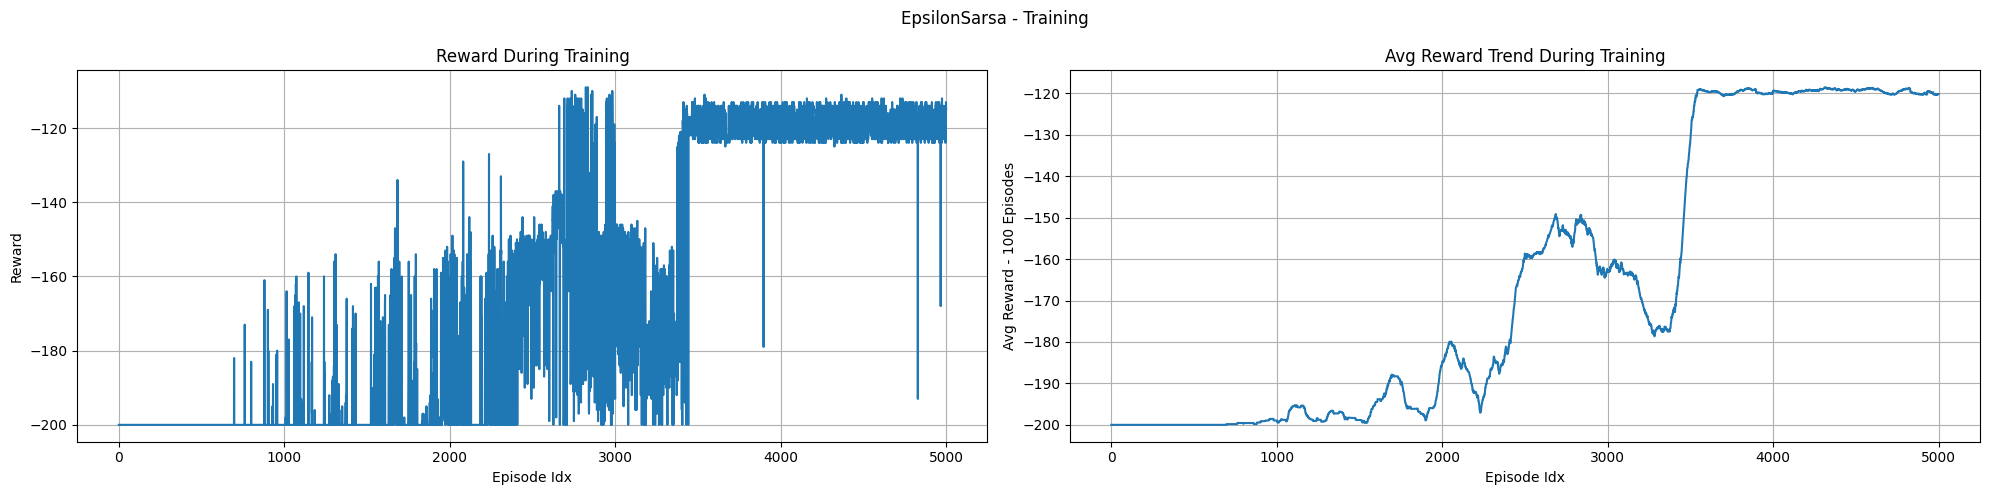

<Figure size 640x480 with 0 Axes>

In [167]:
if (os.path.exists(EPSILON_TRAINED_FILE_NAME)) :
    with open(EPSILON_TRAINED_FILE_NAME, 'rb') as f:
        epsilonTrainedDict = pickle.load(f)
else :
    epsilonTrainedDict = {}

epsilonQ, _ = trainAgent(EpsilonQ, EPSILON_TRAINED_FILE_NAME, epsilonTrainedDict, epsilonParamsDict, TRAIN_EPISODES)
epsilonSarsa, _ = trainAgent(EpsilonSarsa, EPSILON_TRAINED_FILE_NAME, epsilonTrainedDict, epsilonParamsDict, TRAIN_EPISODES)

In entrampi i casi vediamo come vi sia una stabilizzazione nel reward ottenuto.

### Testing

Testiamo le politiche apprese su due ambienti inizializzati con un seed diverso.

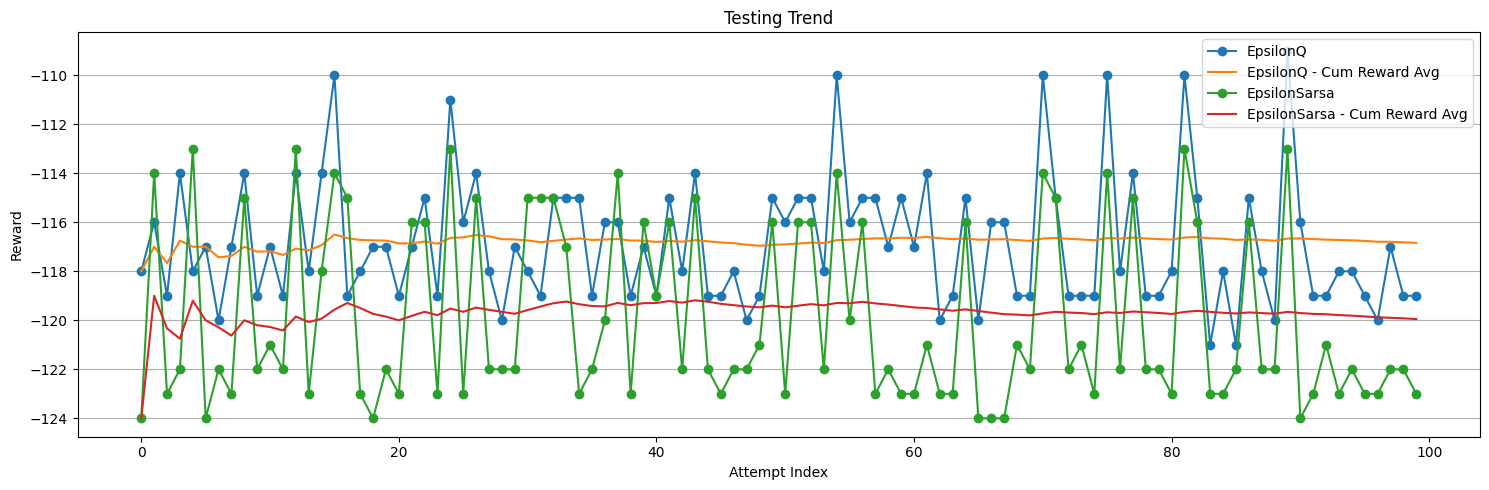

<Figure size 640x480 with 0 Axes>

In [168]:
plotTestTrend([epsilonQ, epsilonSarsa], TEST_EPISODES, TEST_SEED)

In [169]:
drawTestTable([epsilonQ, epsilonSarsa], TEST_EPISODES, TEST_SEED)

                                     Testing Reward Info                                     
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName  ┃ Avg Reward ┃ Reward Std Dev    ┃ Confidence Interval 95%                   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ EpsilonQ     │ -116.84    │ 2.64090893443905  │ -117.36665351135917 / -116.31334648864083 │
│ EpsilonSarsa │ -119.95    │ 3.636963018783667 │ -120.67528791869636 / -119.22471208130365 │
└──────────────┴────────────┴───────────────────┴───────────────────────────────────────────┘

Analizzando i risultati grafici e tabulari, vediamo come tra i due vi sia mediamente una differenza di circa 3 step; mediamente comunque la soluzione basata su QLearning sembra comportarsi meglio e con una varianza minore.

## Softmax Action-Selection
Vediamo se una scelta diversa delle azioni impatta i risultati dell'algoritmo e consideriamo una Softmax-Action-Selection

Di seguito il parametro $\epsilon$ viene usato nel ruolo del $\tau$.

### Tuning

In [170]:
TAU_PARAMS_FILE_NAME = "TauParams.pkl"
if (os.path.exists(TAU_PARAMS_FILE_NAME)) :
    with open(TAU_PARAMS_FILE_NAME, 'rb') as f:
        tauParamsDict = pickle.load(f)
else :
    tauParamsDict = {}

tuneBucketLearner(TauQ, TRAIN_EPISODES, tauParamsDict, TAU_PARAMS_FILE_NAME)
tuneBucketLearner(TauSarsa, TRAIN_EPISODES, tauParamsDict, TAU_PARAMS_FILE_NAME)

[0.18552005209130343, 1.0, 0.5]

In [171]:
table = buildTable("Best Params", ["LearnerName", "Alpha", "Gamma", "Tau"], [False, False, True, True, True])
for key in tauParamsDict :
    table.add_row(key, str(tauParamsDict[key][0]), str(tauParamsDict[key][1]), str(tauParamsDict[key][2]))

Console().print(table)

                    Best Params                    
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━┓
┃ LearnerName ┃ Alpha               ┃ Gamma ┃ Tau ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━┩
│ TauQ        │ 0.21173947219583908 │ 1.0   │ 1.0 │
│ TauSarsa    │ 0.18552005209130343 │ 1.0   │ 0.5 │
└─────────────┴─────────────────────┴───────┴─────┘

### Addestramento

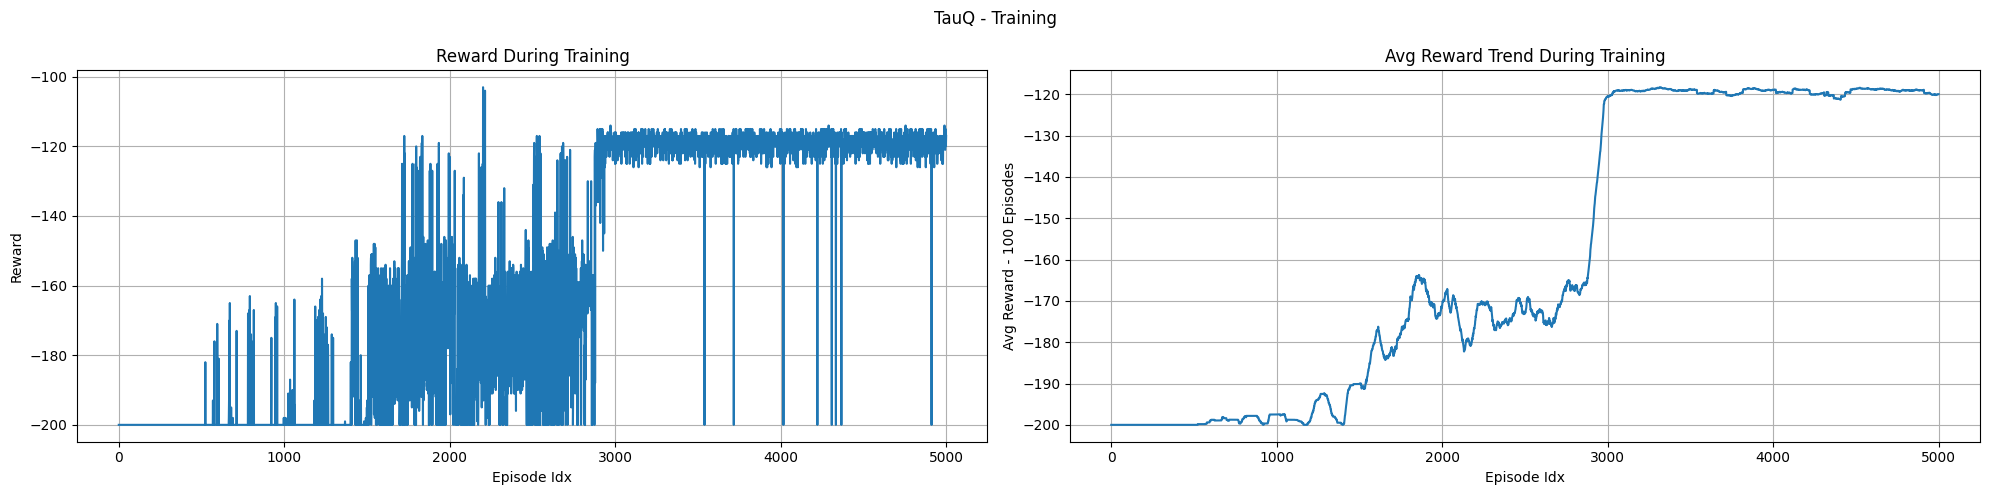

<Figure size 640x480 with 0 Axes>

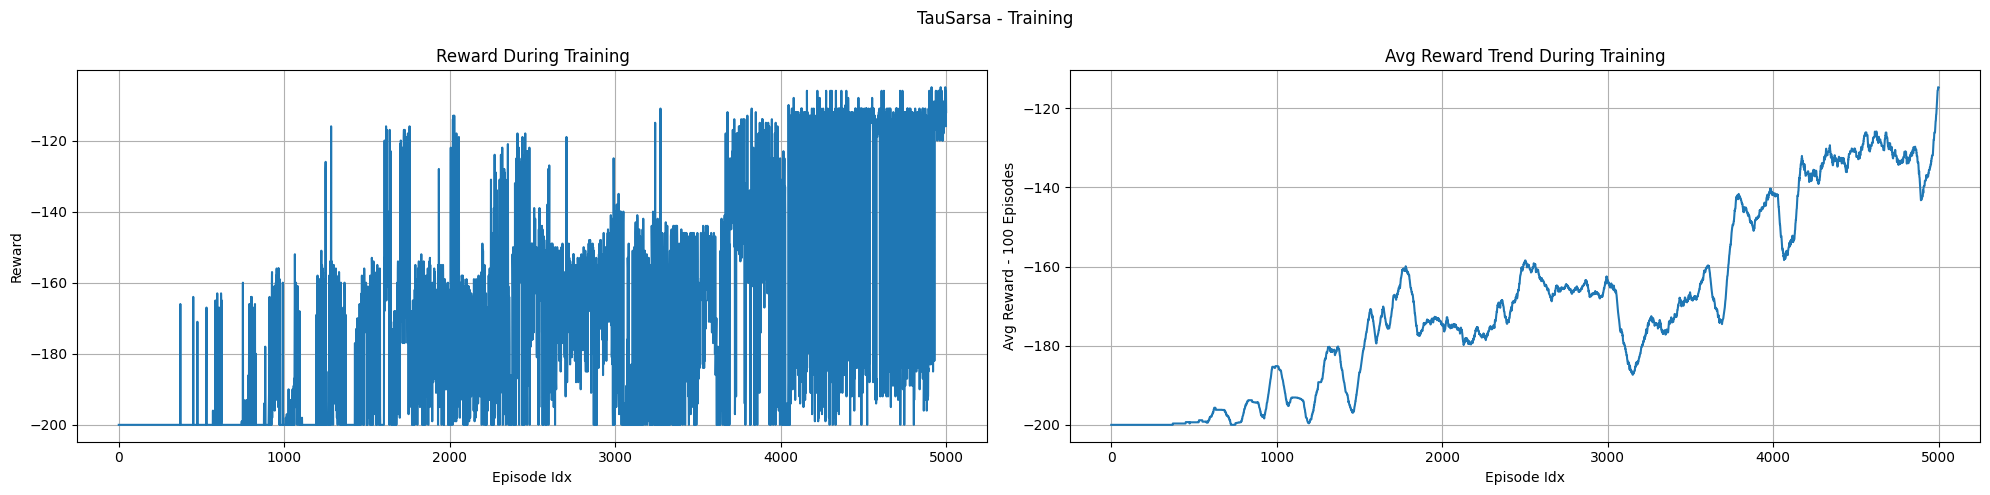

<Figure size 640x480 with 0 Axes>

In [172]:
TAU_TRAINED_FILE_NAME = "TauTrained.pkl"

if (os.path.exists(TAU_TRAINED_FILE_NAME)) :
    with open(TAU_TRAINED_FILE_NAME, 'rb') as f:
        tauTrainedDict = pickle.load(f)
else :
    tauTrainedDict = {}

tauQ, _ = trainAgent(TauQ, TAU_TRAINED_FILE_NAME, tauTrainedDict, tauParamsDict, TRAIN_EPISODES)
tauSarsa, _ = trainAgent(TauSarsa, TAU_TRAINED_FILE_NAME, tauTrainedDict, tauParamsDict, TRAIN_EPISODES)

### Testing

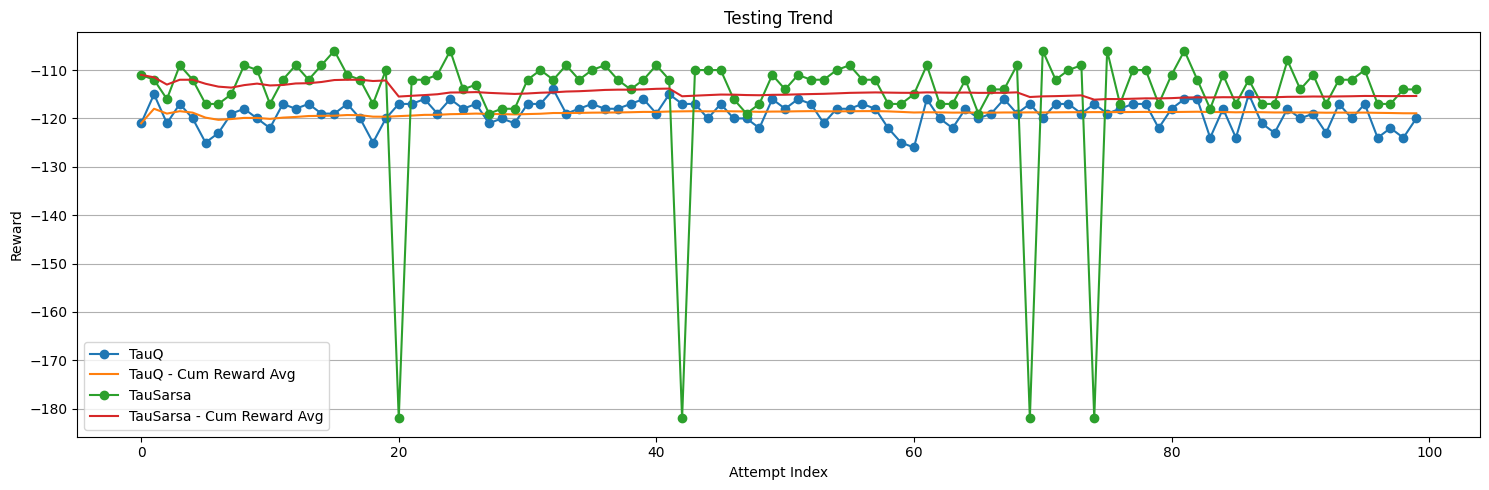

<Figure size 640x480 with 0 Axes>

In [173]:
plotTestTrend([tauQ, tauSarsa], TEST_EPISODES, TEST_SEED)

In [174]:
drawTestTable([tauQ, tauSarsa], TEST_EPISODES, TEST_SEED)

                                     Testing Reward Info                                     
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName ┃ Avg Reward ┃ Reward Std Dev     ┃ Confidence Interval 95%                   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ TauQ        │ -118.94    │ 2.572236381050544  │ -119.45295874100779 / -118.4270412589922  │
│ TauSarsa    │ -115.36    │ 13.994656122963509 │ -118.15083261497938 / -112.56916738502062 │
└─────────────┴────────────┴────────────────────┴───────────────────────────────────────────┘

Nel caso della Softmax Action Selection, sembra essere il Sarsa ad avere le prestazioni medie migliori, sebbene caratterizzato da una varianza maggiore dovuta ai picchi negativi che possiamo vedere nella rappresentazione grafica.

## Confronto
Analizzando i risultati, vediamo come entrambi gli approcci mostrino dei risultati abbastanza simili in termini di valore medio del reward. Allo stesso tempo possiamo vedere come il risultato migliore del QLearning si ottenga con l'approccio $\epsilon$-greedy, mentre nel caso del Sarsa l'approccio migliore risulti essere quello con Softmax Action Selection.

# Soluzione con approssimazione

## Approssimazione con DQN

### Soluzione A Mano con PyTorch

La soluzione con approssimazione è state realizzata usando la libreria Pytorch: l'uso di questa libreria è risultato molto più efficiente da un punto di vista temporale rispetto all'uso di Keras.

In generale è stato notato che l'uso della GPU non porta particolari miglioramenti in termini prestazionali: questo è probabilmente dovuto al fatto che essendo i batch su cui si fanno i passi piccoli ed essendo fatto un singolo passo per volta, l'overhead di spostamento dei dati da memoria principale a memoria globale della GPU prevale sul tempo di esecuzione.

In [175]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [176]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'nextState', 'notTerminated'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        self.rng = np.random.default_rng(seed = 0)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        indices = self.rng.choice(len(self.memory), size=batch_size)  # Campionamento senza sostituzione
        return [self.memory[i] for i in indices]

    def __len__(self):
        return len(self.memory)

In [177]:
class DQNFunction(QFunction) :

    def __init__(
            self, 
            policyNet : torch.nn.Sequential, 
            targetNet : torch.nn.Sequential, 
            updateTargetPeriod : int = 16, 
            batchSize : int = 128, 
            memoryCapacity : int = 10_000
        ) :
        self.policyNet = policyNet
        self.targetNet = targetNet

        self.updateTargetPeriod = updateTargetPeriod
        self.updateCount = 0
        self.batchSize = batchSize

        self.targetNet.load_state_dict(self.policyNet.state_dict())

        self.replayMemory = ReplayMemory(memoryCapacity)

        self.optimizer = torch.optim.AdamW(self.policyNet.parameters(), lr=1e-4, amsgrad=True)
        

    def getValue(self, state, action) -> float:
        # convertedState = tf.convert_to_tensor([state])
        # return self.policyNet.predict_on_batch(convertedState)[action]
        with torch.no_grad() :
            convertedState = torch.tensor(state)
            result = self.policyNet.forward(convertedState)
            return result.numpy()[action]
    
    def getValues(self, state) -> np.ndarray:
        # convertedState = tf.convert_to_tensor([state])
        # value = self.policyNet.predict_on_batch(convertedState)
        # return value
        with torch.no_grad() :
            convertedState = torch.tensor(state)
            result = self.policyNet.forward(convertedState)
            return result.numpy()
    
    def updateFunction(self, currentState, action, reward, nextState, terminated, alpha, gamma, target):
        self.replayMemory.push(
            torch.tensor(currentState, device = device).unsqueeze(0), 
            torch.tensor([action], dtype = torch.int64, device = device), 
            torch.tensor([reward], dtype = torch.float32, device = device), 
            torch.tensor(nextState, device = device).unsqueeze(0),
            torch.tensor([not terminated], dtype = torch.bool)
        )

        if (len(self.replayMemory) < self.batchSize) :
            return
        
        batch = self.replayMemory.sample(self.batchSize)
        batch = Transition(*zip(*batch))

        stateBatch = torch.cat(batch.state)
        actionBatch = torch.cat(batch.action).unsqueeze(1)
        rewardBatch = torch.cat(batch.reward)
        nextStateBatch = torch.cat(batch.nextState)
        notTerminalBatch = torch.cat(batch.notTerminated)


        predictedValues : torch.Tensor = self.policyNet.forward(stateBatch).gather(1, actionBatch)

        nextStateValues = torch.zeros(self.batchSize)
        with torch.no_grad():
            nextStateValues[notTerminalBatch] = self.targetNet.forward(nextStateBatch[notTerminalBatch]).max(1).values
            # Compute the expected Q values
        expectedValues : torch.Tensor = rewardBatch + gamma * nextStateValues
        expectedValues = expectedValues.unsqueeze(1)

        self._trainNetworks(predictedValues, expectedValues)
        
    
    def _trainNetworks(self, predictedValues, expectedValues) :

        # loss = torch.nn.functional.mse_loss(predictedValues, expectedValues)
        loss = torch.nn.functional.smooth_l1_loss(predictedValues, expectedValues)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policyNet.parameters(), 100)
        self.optimizer.step()

        self.updateCount += 1
        if (self.updateCount % self.updateTargetPeriod == 0) :
            self.targetNet.load_state_dict(self.policyNet.state_dict())

In [178]:
def buildNetwork(inputUnits : int, outputUnits : int, hiddenUnits : int) :
    return torch.nn.Sequential(
        torch.nn.Linear(inputUnits, hiddenUnits),
        torch.nn.ReLU(),
        torch.nn.Linear(hiddenUnits, hiddenUnits),
        torch.nn.ReLU(),
        torch.nn.Linear(hiddenUnits, outputUnits),
    )

In [179]:
torch.manual_seed(TORCH_RANDOM_STATE)

policyNet = buildNetwork(2, ACTION_SPACE, 128)
targetNet = buildNetwork(2, ACTION_SPACE, 128)

dqnFunction = DQNFunction(policyNet, targetNet, 128, 1024, 100_000)
policy = EpsilonQ(0.21, 0.8, 0.5, dqnFunction, TRAIN_SEED, 0.5)

policy = Agent(policy)
# learnArray = policy.train(TRAIN_EPISODES, TRAIN_SEED)
# plotTrainTrend(learnArray, TRAIN_EPISODES, "QLearner")

Questa implementazione, sebbene corretta, richiede un tempo di esecuzione molto alto e risulta ancora poco efficiente per eseguire l'addestramento su molti episodi.

### Soluzione con Stable-Baseline3
Stable-Baseline3 è una libreria Python che usa PyTorch a basso livello e che fornisce già implementati un numero molto alto di algoritmi di RL che risultano molto efficienti.

In [180]:
from stable_baselines3 import DQN
from stable_baselines3.dqn import MlpPolicy
from stable_baselines3.common.monitor import Monitor

Implementiamo di seguito una Policy che prende in input una DQN della libreria SB3. In questo caso l'unico metodo da implementare è la *chooseAction*: infatti gli altri due metodi sono usati in fase di addestramento ma, come vediamo in seguito, l'addestramento della DQN viene fatto esternamente.

In [181]:
class DQNPolicy(Policy) :

    def __init__(self, dqn : DQN) :
        super().__init__(0, 0, 0, None)
        self.dqn = dqn

    def chooseAction(self, state, training) -> int:
        action, _states = self.dqn.predict(state, deterministic=True)
        return action

    ## Questa funzione viene chiamata solo in fase di training, che viene eseguito fuori sulla DQN passata
    ## Come parametro, quindi non deve fare nulla
    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        pass

    ## Questa funzione viene chiamata solo in fase di training, che viene eseguito fuori sulla DQN passata
    ## Come parametro, quindi non deve fare nulla
    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        pass

#### Tuning
Per il tuning degli iperparametri si è fatto riferimento a quelli trovati dall'estensione *stable-baseline3 zoo*; gli iperparametri migliori individuati dall'estensione sono (https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/dqn.yml):
- 'batch_size', 128
- 'buffer_size', 10000
- 'exploration_final_eps', 0.07
- 'exploration_fraction', 0.2
- 'gamma', 0.98
- 'gradient_steps', 8
- 'learning_rate', 0.004
- 'learning_starts', 1000
- 'n_timesteps', 120000.0
- 'policy', 'MlpPolicy'
- 'policy_kwargs', 'dict(net_arch=[256, 256])'
- 'target_update_interval', 600
- 'train_freq', 16
- 'normalize', False

#### Addestramento

In [182]:
BEST_DQN_MONITOR_FILE_NAME = "BestDqnMonitor.pkl"
BEST_DQN_TRAINED_FILE_NAME = "BestDqn.zip"

In [183]:
if (os.path.exists(BEST_DQN_MONITOR_FILE_NAME) and os.path.exists(BEST_DQN_TRAINED_FILE_NAME)) :
    with open(BEST_DQN_MONITOR_FILE_NAME, 'rb') as f:
        monitor = pickle.load(f)
    dqn = DQN.load(BEST_DQN_TRAINED_FILE_NAME)

Viene quindi costruita la DQN sulla base degli iperparametri travati dall'estensione. Il metodo *learn* della DQN prende come parametro il valore *total_timesteps* che rappresenta il numero di step totali che vengono eseguiti sull'ambiente; come valore è stato impostato, per mantenersi coerenti con l'addestramento degli altri metodi, un numero di timestep pari a $200 * TRAIN\_EPISODES$, dove $200$ rappresenta il numero massimo ti timestep per episodio.

Anche in questo modo salviamo la DQN addestrata su un file per non addestrarla una seconda volta. 

L'ambiente di addestramento viene invece racchiuso in una classe *Monitor* che ci permette di monitorare il reward ottenuto dai vari episodi di addestramento.

In [184]:
env = gym.make(PROBLEM_NAME)
env.reset(seed = TRAIN_SEED)
env.action_space.seed(seed = TRAIN_SEED)

monitor = Monitor(env)

if (os.path.exists(BEST_DQN_MONITOR_FILE_NAME) and os.path.exists(BEST_DQN_TRAINED_FILE_NAME)) :
    with open(BEST_DQN_MONITOR_FILE_NAME, 'rb') as f:
        monitor = pickle.load(f)
    dqn = DQN.load(BEST_DQN_TRAINED_FILE_NAME)
    
else :
    dqn = DQN(
        "MlpPolicy",
        env = monitor,
        batch_size = 128,
        exploration_final_eps = 0.07,
        exploration_fraction = 0.2,
        gamma = 0.98,
        gradient_steps = 8,
        learning_rate = 0.004,
        learning_starts = 1000,
        policy_kwargs = dict(net_arch = [256, 256], normalize_images = False),
        target_update_interval = 600,
        train_freq = 16
    )
    dqn.learn(total_timesteps = 200 * TRAIN_EPISODES, progress_bar = True)

    with open(BEST_DQN_MONITOR_FILE_NAME, 'wb') as f:
        pickle.dump(monitor, f)
    dqn.save(BEST_DQN_TRAINED_FILE_NAME)


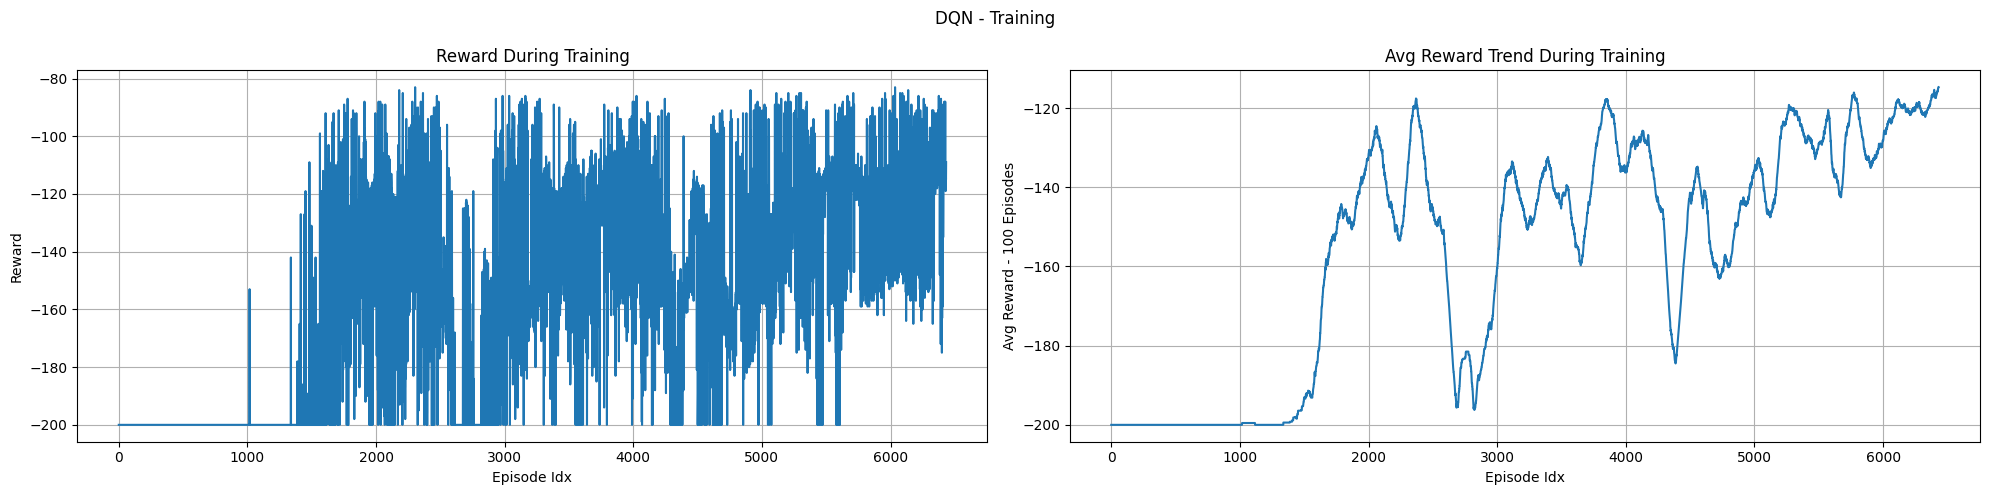

<Figure size 640x480 with 0 Axes>

In [185]:
plotTrainTrend(
    monitor.get_episode_rewards(), 
    len(monitor.get_episode_lengths()),
    "DQN"
)

#### Testing

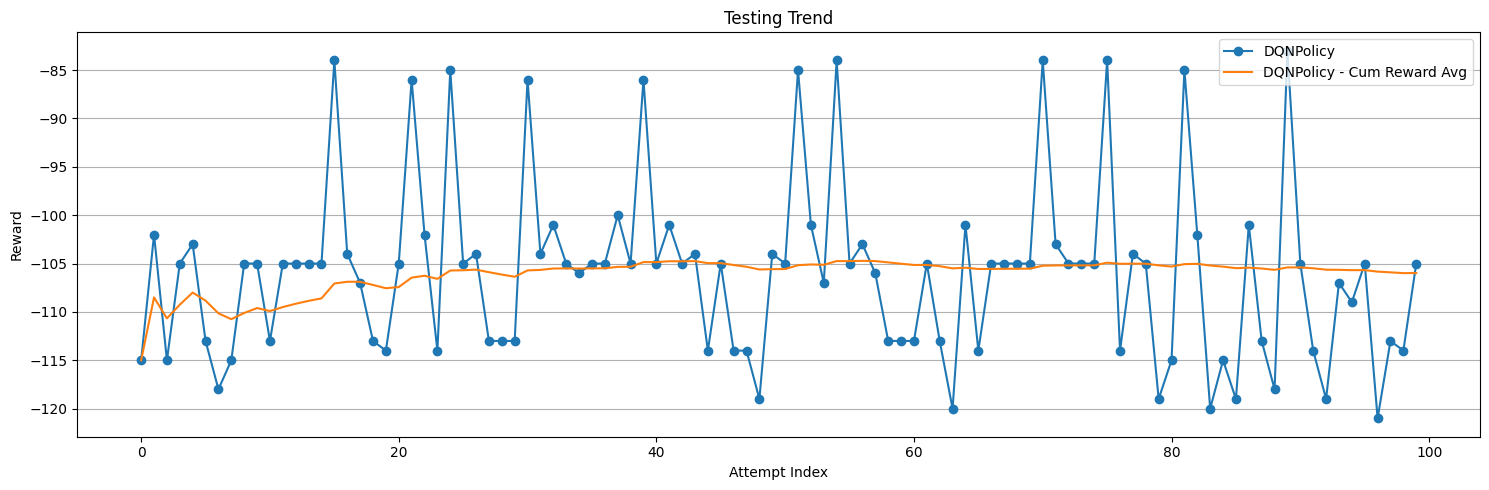

<Figure size 640x480 with 0 Axes>

In [186]:
dqnPolicy = DQNPolicy(dqn)
plotTestTrend([dqnPolicy], TEST_EPISODES, TEST_SEED)

In [187]:
drawTestTable([DQNPolicy(dqn)], TEST_EPISODES, TEST_SEED)

                                    Testing Reward Info                                     
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName ┃ Avg Reward ┃ Reward Std Dev    ┃ Confidence Interval 95%                   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ DQNPolicy   │ -105.98    │ 9.186925492241677 │ -107.81206868892355 / -104.14793131107646 │
└─────────────┴────────────┴───────────────────┴───────────────────────────────────────────┘

# Conclusioni
Alla luce dell'ultimo risultato, la soluzione con DQN risulta essere la migliore, considerato che ci permette di ottenere un reward medio di $-105.98$, con episodi che raggiungono reward anche prossimi al $-85$. D'altro canto c'è da mettere in luce il tempo di addestramento non trascurabile della DQN (da cui in questa sede è stato escluso il tempo necessario al tuning): tenuto conto di questo tempo e della differenza media rispetto alle soluzioni tabulari (tra i $10$ e i $20$ step in media), le soluzioni tabulari risultano comunque più che valide.

## Video
Per mostrare il video dell'agente addestrato con DQN, selezionare la politica tramite indice e modificare il valore della variabile *display* a **True**

In [188]:
policyList = [epsilonQ, epsilonSarsa, tauQ, tauSarsa, dqnPolicy]

selectedPolicy = policyList[0]

agent = Agent(selectedPolicy)

display = False
agent.test(5, TEST_SEED, display = display)

array([-118., -116., -119., -114., -118.])